In [1]:
%matplotlib inline
%mpdaf
import matplotlib.pyplot as plt
from mpdaf.MUSE import get_FSF_from_cube_keywords

from scipy.signal import convolve, fftconvolve

Numpy 1.16.4
Astropy 4.0.dev24901
MPDAF 3.3.dev6+gddcaae1b.d20190611


In [2]:
cube = Cube('/muse/UDF/public/dataproducts/1.0b1/DATACUBE_UDF-10.fits')

In [3]:
cube

<Cube(shape=(3681, 322, 323), unit='1e-20 erg / (Angstrom cm2 s)', dtype='None')>

In [4]:
psf, fwhmpix, fwhm = get_FSF_from_cube_keywords(cube, 25)
psf /= psf.sum(axis=(1,2))[:,None,None]

<ipython-input-4-4266715c6e11>:1: MpdafWarning: Call to deprecated function `get_FSF_from_cube_keywords`. deprecated in favor of mpdaf.MUSE.FSFModel
  psf, fwhmpix, fwhm = get_FSF_from_cube_keywords(cube, 25)


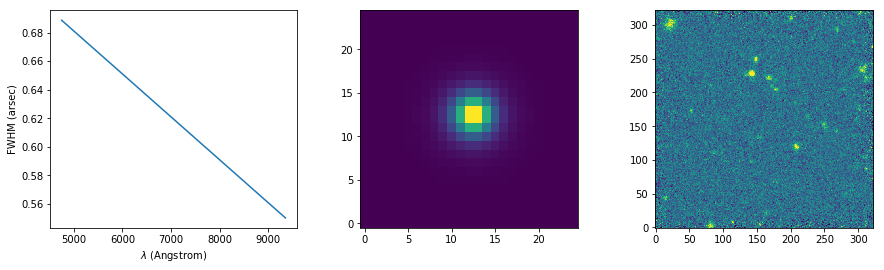

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(cube.wave.coord(), fwhm)
ax1.set_xlabel('$\lambda$ (Angstrom)')
ax1.set_ylabel('FWHM (arsec)')
ax2.imshow(psf[0], origin='lower')
cube[100].plot(ax=ax3, zscale=True);

In [6]:
data = cube.data.filled(0)

In [7]:
nl = 1000

In [8]:
%%time
v1 = []
for subc, subp in zip(data[:nl], psf[:nl]):
    v1.append(fftconvolve(subc, subp, mode='same'))
v1 = np.array(v1)

CPU times: user 2min 51s, sys: 3.12 s, total: 2min 54s
Wall time: 4.49 s


In [9]:
def fftconvolve2(in1, in2, axes=None):
    from scipy import fftpack
    from scipy.signal.signaltools import _centered
    
    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    shape = s1 + s2 - 1

    fshape = [fftpack.helper.next_fast_len(int(d)) for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    #print(shape, fshape, fslice)

    sp1 = np.fft.rfftn(in1, fshape[1:], axes=axes)
    sp2 = np.fft.rfftn(in2, fshape[1:], axes=axes)
    ret = (np.fft.irfftn(sp1 * sp2, fshape[1:], axes=axes)[fslice].copy())
    #print(ret.shape)
    return _centered(ret, s1)

In [10]:
%time v2 = fftconvolve2(data[:nl], psf[:nl], axes=(1,2))

CPU times: user 39.1 s, sys: 14.3 s, total: 53.4 s
Wall time: 6.54 s


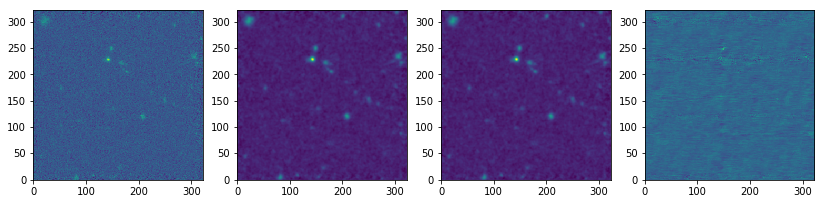

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))
ax1.imshow(cube.data[100], origin='lower')
ax2.imshow(v1[100], origin='lower')
ax3.imshow(v2[100], origin='lower')
ax4.imshow(v1[100]-v2[100], origin='lower')

In [12]:
from astropy.convolution import convolve_fft as convolve_fft_ast, convolve as convolve_ast

In [14]:
%%time
v3 = []
for subc, subp in zip(data[:nl], psf[:nl]):
    v3.append(convolve_ast(subc, subp, nan_treatment='fill'))
v3 = np.array(v3)

CPU times: user 1min 15s, sys: 1.17 s, total: 1min 16s
Wall time: 1min 16s


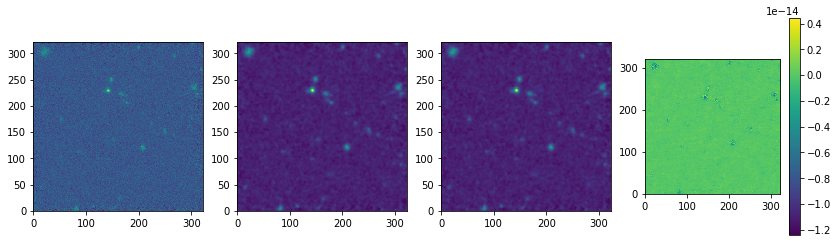

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))
ax1.imshow(cube.data[100], origin='lower')
ax2.imshow(v1[100], origin='lower')
ax3.imshow(v3[100], origin='lower')
cax = ax4.imshow(v1[100]-v3[100], origin='lower')
plt.colorbar(cax)

In [16]:
%%time
v4 = []
for subc, subp in zip(cube._data[:nl], psf[:nl]):
    v4.append(convolve_fft_ast(subc, subp, nan_treatment='interpolate'))
v4 = np.array(v4)

CPU times: user 5min, sys: 10.1 s, total: 5min 10s
Wall time: 16.3 s


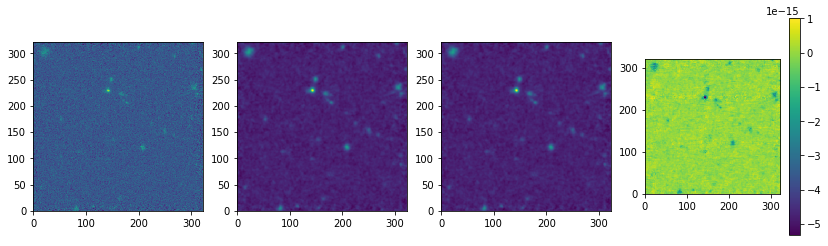

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))
ax1.imshow(cube.data[100], origin='lower')
ax2.imshow(v1[100], origin='lower')
ax3.imshow(v4[100], origin='lower')
cax = ax4.imshow(v1[100]-v4[100], origin='lower')
plt.colorbar(cax)